In [65]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [66]:
API_KEY = "QCC4AQUW1ZKX4T7P"
symbol = "GOOG"

In [67]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}&datatype=csv"

In [68]:
response = requests.get(url)

In [69]:
# print response
if response.status_code == 200:
    with open(f'{symbol}_stock_data.csv', 'wb') as file:
        file.write(response.content)
    print(f"Data saved to {symbol}_stock_data.csv")


Data saved to GOOG_stock_data.csv


In [70]:
# store the data in a pandas dataframe
df = pd.read_csv(f'{symbol}_stock_data.csv', index_col=0, parse_dates=True)

In [71]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.tail())

               open     high     low   close    volume
timestamp                                             
2025-06-30  180.785  181.580  175.50  177.39  43964599
2025-07-01  176.805  177.220  174.66  176.91  25778460
2025-07-02  176.545  179.935  176.09  179.76  19325861
2025-07-03  179.820  180.770  178.19  180.55  13287389
2025-07-07  180.135  180.340  176.64  177.56  20991357


In [72]:
# Add multiple indicators
df.ta.rsi(append=True)                      # RSI
df.ta.macd(append=True)                     # MACD (MACDEXT style)
df.ta.ema(length=20, append=True)           # EMA20
df.ta.sma(length=50, append=True)           # SMA50
df.ta.obv(append=True)                      # On Balance Volume
df.ta.bbands(append=True)                   # Bollinger Bands
df.ta.cci(append=True)                      # CCI
df.ta.atr(append=True)                      # ATR

# Clean up: Drop NaN values created by indicators (lookback periods)
df.dropna(inplace=True)

In [73]:
# Calculate ADX with 14-day period (default)
adx = ta.adx(df['high'], df['low'], df['close'])

# Merge into your main DataFrame
df = pd.concat([df, adx], axis=1)

# Optional: Simplify naming
df.rename(columns={
    'ADX_14': 'ADX',
    'DMP_14': 'DI+',
    'DMN_14': 'DI-'
}, inplace=True)

In [74]:
def trend_direction(row):
    if row['ADX'] > 25:
        if row['DI+'] > row['DI-']:
            return 1   # strong uptrend
        else:
            return -1  # strong downtrend
    return 0  # no clear trend

df['trend_signal'] = df.apply(trend_direction, axis=1)

In [75]:
# Calculate MA
df['MA100'] = df['close'].rolling(100).mean()
df['MA200'] = df['close'].rolling(200).mean()
df['MA_signal'] = (df['MA100'] > df['MA200']).astype(int)

# Drop NA
df = df.dropna()

In [76]:
# 1️⃣ Select features
features = ['open', 'high', 'low', 'close', 'volume',
            'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'EMA_20', 'SMA_50', 'OBV', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
            'BBB_5_2.0', 'BBP_5_2.0', 'CCI_14_0.015', 'ATRr_14',
            'ADX', 'DI+', 'DI-', 'trend_signal', 'MA100', 'MA200', 'MA_signal']

# 2️⃣ Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# 3️⃣ Create sequences
X = []
y = []

sequence_length = 60  # last 60 days
target_col_index = features.index('close')  # we'll predict next 'close' price

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    ohlc_indices = [features.index(col) for col in ['open', 'high', 'low', 'close']]
    y.append(scaled_data[i][ohlc_indices])


X, y = np.array(X), np.array(y)

In [77]:
model = load_model('stock_trend_model.h5')

In [78]:
# Number of test samples
num_test = len(X)

# Start from sequence_length + training size
test_dates = df.index[-num_test:]

In [79]:
# --- Predict ---
pred_scaled = model.predict(X)

# --- Rebuild full input to inverse transform OHLC only ---
full_pred = np.zeros((pred_scaled.shape[0], len(features)))
for i, col in enumerate(['open', 'high', 'low', 'close']):
    col_idx = features.index(col)
    full_pred[:, col_idx] = pred_scaled[:, i]

pred_inv = scaler.inverse_transform(full_pred)

# --- Extract OHLC ---
predicted_df = pd.DataFrame(
    pred_inv[:, [features.index(c) for c in ['open', 'high', 'low', 'close']]],
    columns=['open', 'high', 'low', 'close'],
    index=df.index[sequence_length:]  # align with X
)

79/79 [==============================] - 4s 34ms/step



📊 Evaluation Metrics:

--- OPEN ---
MAE: 49.1161
RMSE: 70.7608
R2: 0.9921

--- HIGH ---
MAE: 50.6771
RMSE: 72.2091
R2: 0.9919

--- LOW ---
MAE: 49.1051
RMSE: 69.9301
R2: 0.9921

--- CLOSE ---
MAE: 48.2012
RMSE: 70.8409
R2: 0.9920


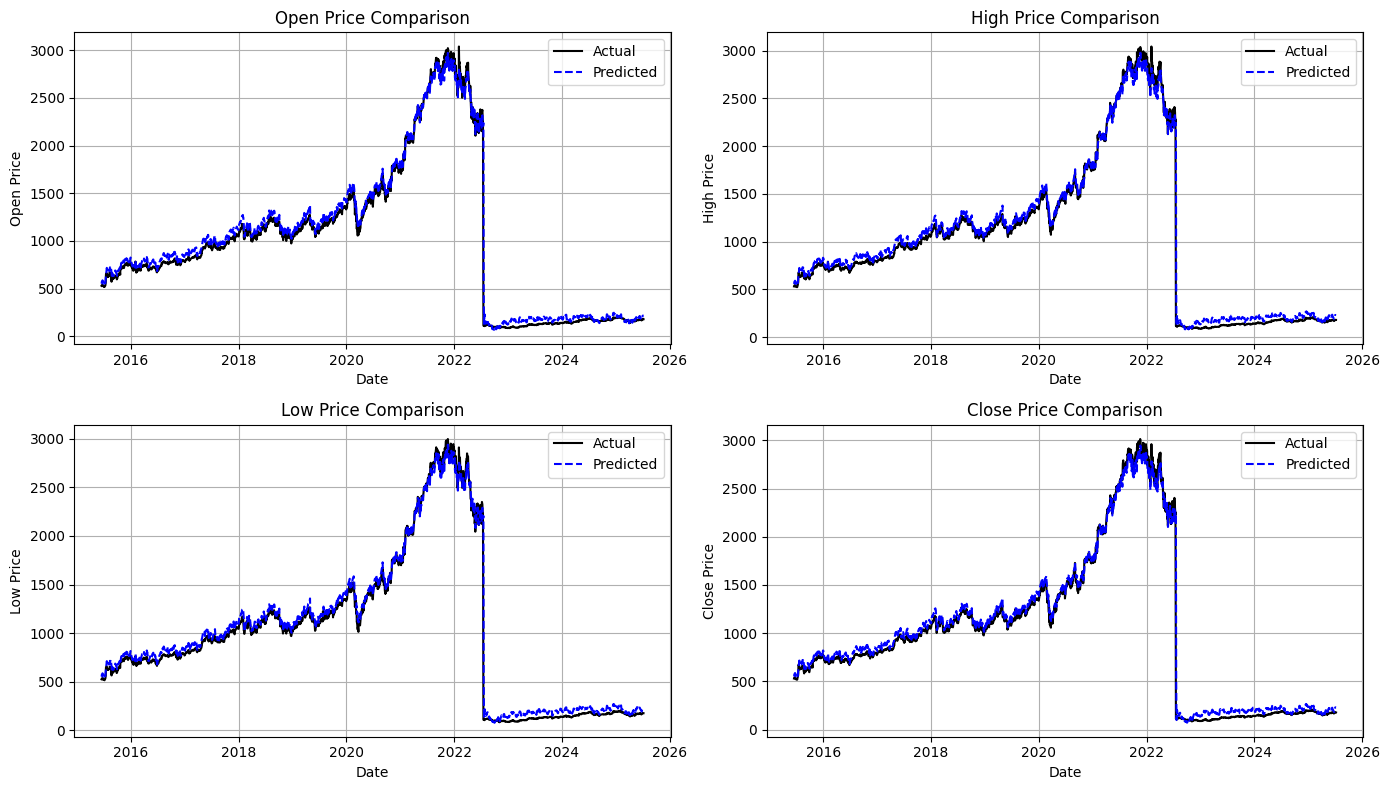

In [80]:
# --- Extract actual OHLC values from df for the same prediction range ---
actual_df = df.loc[predicted_df.index, ['open', 'high', 'low', 'close']].copy()

# --- Evaluation metrics function ---
def evaluate_predictions(actual, predicted):
    metrics = {}
    for col in ['open', 'high', 'low', 'close']:
        y_true = actual[col].values
        y_pred = predicted[col].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        metrics[col] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics

# --- Compute and display metrics ---
metrics = evaluate_predictions(actual_df, predicted_df)

print("\n📊 Evaluation Metrics:")
for col in metrics:
    print(f"\n--- {col.upper()} ---")
    for metric_name, value in metrics[col].items():
        print(f"{metric_name}: {value:.4f}")

# --- Plot actual vs predicted OHLC ---
plt.figure(figsize=(14, 8))
for i, col in enumerate(['open', 'high', 'low', 'close']):
    plt.subplot(2, 2, i + 1)
    plt.plot(actual_df[col], label='Actual', color='black')
    plt.plot(predicted_df[col], label='Predicted', linestyle='dashed', color='blue')
    plt.title(f'{col.capitalize()} Price Comparison')
    plt.xlabel('Date')
    plt.ylabel(f'{col.capitalize()} Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [81]:
# 1️⃣ Extract the last 60 rows of scaled feature data
last_60 = scaled_data[-60:]  # shape: (60, num_features)

# 2️⃣ Do NOT remove OHLC columns; use all features as input
X_input = last_60  # shape: (60, 26)

# 3️⃣ Reshape for LSTM input
X_input = X_input.reshape(1, 60, X_input.shape[1])  # shape: (1, 60, 26)

# 4️⃣ Predict scaled OHLC values
predicted_scaled_ohlc = model.predict(X_input)[0]  # shape: (4,) — open, high, low, close

# 5️⃣ Prepare full zero row for inverse transform
dummy_row = np.zeros((1, len(features)))
for i, col in enumerate(['open', 'high', 'low', 'close']):
    col_idx = features.index(col)
    dummy_row[0][col_idx] = predicted_scaled_ohlc[i]

# 6️⃣ Inverse transform to get real OHLC prices
predicted_ohlc = scaler.inverse_transform(dummy_row)[0]
pred_open = predicted_ohlc[features.index('open')]
pred_high = predicted_ohlc[features.index('high')]
pred_low = predicted_ohlc[features.index('low')]
pred_close = predicted_ohlc[features.index('close')]

# 7️⃣ Print result
print(f"\n📈 Predicted Next OHLC Prices:")
print(f"Open  : {pred_open:.2f}")
print(f"High  : {pred_high:.2f}")
print(f"Low   : {pred_low:.2f}")
print(f"Close : {pred_close:.2f}")


1/1 [==============================] - 1s 1s/step

📈 Predicted Next OHLC Prices:
Open  : 204.51
High  : 219.24
Low   : 222.77
Close : 216.82


In [82]:
# Filter data from the last 3 years
cutoff_date = datetime.now() - timedelta(days=3*365)
df_recent = df[df.index >= cutoff_date]

In [83]:
def get_news_headlines(keyword="TCS", num_days=30):
    headlines = {}

    for i in range(num_days):
        date = datetime.now() - timedelta(days=i)
        formatted_date = date.strftime('%Y-%m-%d')
        
        # Google News RSS (can filter date later)
        url = f"https://news.google.com/rss/search?q={keyword}+when:{i}d"
        r = requests.get(url)
        soup = BeautifulSoup(r.content, features="html.parser")
        items = soup.findAll("item")

        # Limit number of headlines per day
        limited_titles = [item.title.text for item in items[:5]]  # Adjust the number as needed
        headlines[formatted_date] = limited_titles

    return headlines


In [84]:
def compute_daily_sentiment(headlines_dict):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = {}

    for date, titles in headlines_dict.items():
        scores = [analyzer.polarity_scores(title)['compound'] for title in titles]
        avg_score = sum(scores) / len(scores) if scores else 0
        sentiment_scores[date] = avg_score

    return sentiment_scores

In [85]:
headline_data = get_news_headlines(symbol, num_days=90)
sentiment_scores = compute_daily_sentiment(headline_data)

sentiment_df = pd.DataFrame(list(sentiment_scores.items()), columns=['Date', 'Sentiment'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df.set_index('Date', inplace=True)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [86]:
avg_sentiment_score = sentiment_df['Sentiment'].mean()
print(f"🧠 Average Sentiment Score over 90 days: {avg_sentiment_score:.4f}")


🧠 Average Sentiment Score over 90 days: 0.1257


In [87]:
sentiment_df.head()

,Sentiment
Date,
2025-07-08,0.05448
2025-07-07,-0.09330
2025-07-06,0.04968
2025-07-05,-0.09330
2025-07-04,-0.09330


In [88]:
def recompute_indicators(df):
    df['EMA_20'] = ta.ema(df['close'], length=20)
    df['SMA_50'] = ta.sma(df['close'], length=50)
    df['MA100'] = ta.sma(df['close'], length=100)
    df['MA200'] = ta.sma(df['close'], length=200)

    bbands = ta.bbands(df['close'], length=5)
    df['BBL_5_2.0'] = bbands['BBL_5_2.0']
    df['BBM_5_2.0'] = bbands['BBM_5_2.0']
    df['BBU_5_2.0'] = bbands['BBU_5_2.0']
    df['BBB_5_2.0'] = bbands['BBB_5_2.0']
    df['BBP_5_2.0'] = bbands['BBP_5_2.0']

    df['RSI_14'] = ta.rsi(df['close'], length=14)
    df['CCI_14_0.015'] = ta.cci(df['high'], df['low'], df['close'], length=14)
    df['ATRr_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

    macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
    df['MACD_12_26_9'] = macd['MACD_12_26_9']
    df['MACDh_12_26_9'] = macd['MACDh_12_26_9']
    df['MACDs_12_26_9'] = macd['MACDs_12_26_9']

    df['OBV'] = ta.obv(df['close'], df['volume'])

    adx = ta.adx(df['high'], df['low'], df['close'], length=14)
    df['ADX'] = adx['ADX_14']
    df['DI+'] = adx['DMP_14']
    df['DI-'] = adx['DMN_14']

    # Trend signals (optional/custom)
    df['trend_signal'] = (df['MA100'] > df['MA200']).astype(int)
    df['MA_signal'] = (df['close'] > df['MA100']).astype(int)

    # Fill NA to avoid breaking scaler
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df


In [ ]:
from copy import deepcopy
import pandas as pd
import numpy as np

# 🔁 Start with a deep copy to preserve original data
df_working = deepcopy(df)
num_predictions = 120
k = 0.2  # scaling factor for sentiment influence
ohlc_cols = ['open', 'high', 'low', 'close']
ohlc_indices = [features.index(c) for c in ohlc_cols]

for i in range(num_predictions):
    # 1️⃣ Prepare input window from latest 60 rows
    df_features = df_working[features].copy()
    scaled = scaler.transform(df_features)
    input_window = scaled[-60:]  # shape: (60, n_features)

    # 2️⃣ Use all features as input (do NOT remove OHLC columns)
    X_input = input_window.reshape(1, 60, input_window.shape[1])

    # 3️⃣ Predict OHLC (scaled)
    pred_scaled_ohlc = model.predict(X_input)[0]  # shape: (4,) for open, high, low, close

    # 4️⃣ Adjust only 'close' using sentiment
    pred_scaled_ohlc[3] += pred_scaled_ohlc[3] * k * avg_sentiment_score

    # 5️⃣ Create dummy row for inverse scaling
    dummy_row = np.zeros((1, len(features)))
    for idx, col in enumerate(ohlc_cols):
        col_idx = features.index(col)
        dummy_row[0][col_idx] = pred_scaled_ohlc[idx]

    # 6️⃣ Inverse transform full feature row
    predicted_vals = scaler.inverse_transform(dummy_row)[0]
    predicted_open = predicted_vals[features.index('open')]
    predicted_high = predicted_vals[features.index('high')]
    predicted_low = predicted_vals[features.index('low')]
    predicted_close = predicted_vals[features.index('close')]

    # 7️⃣ Pull last known row for non-predicted features
    last_row = df_working.iloc[-1]

    # 8️⃣ Construct new row
    new_row = {
        'open': predicted_open,
        'high': predicted_high,
        'low': predicted_low,
        'close': predicted_close,
        'volume': last_row['volume']  # or modify if you want to predict volume too
    }

    # Append dummy values for technical indicators
    for feat in features:
        if feat not in new_row:
            new_row[feat] = np.nan

    df_working = pd.concat([df_working, pd.DataFrame([new_row])], ignore_index=True)

    # 9️⃣ Recompute technical indicators
    df_working = recompute_indicators(df_working)

# 🔟 Extract predicted future close prices
predicted_future_df = df_working[-num_predictions:][['close']].copy()
predicted_future_df.columns = ['Predicted_Close']

# Add future dates (business days)
last_date = pd.to_datetime(df.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_predictions, freq='B')
predicted_future_df.index = future_dates


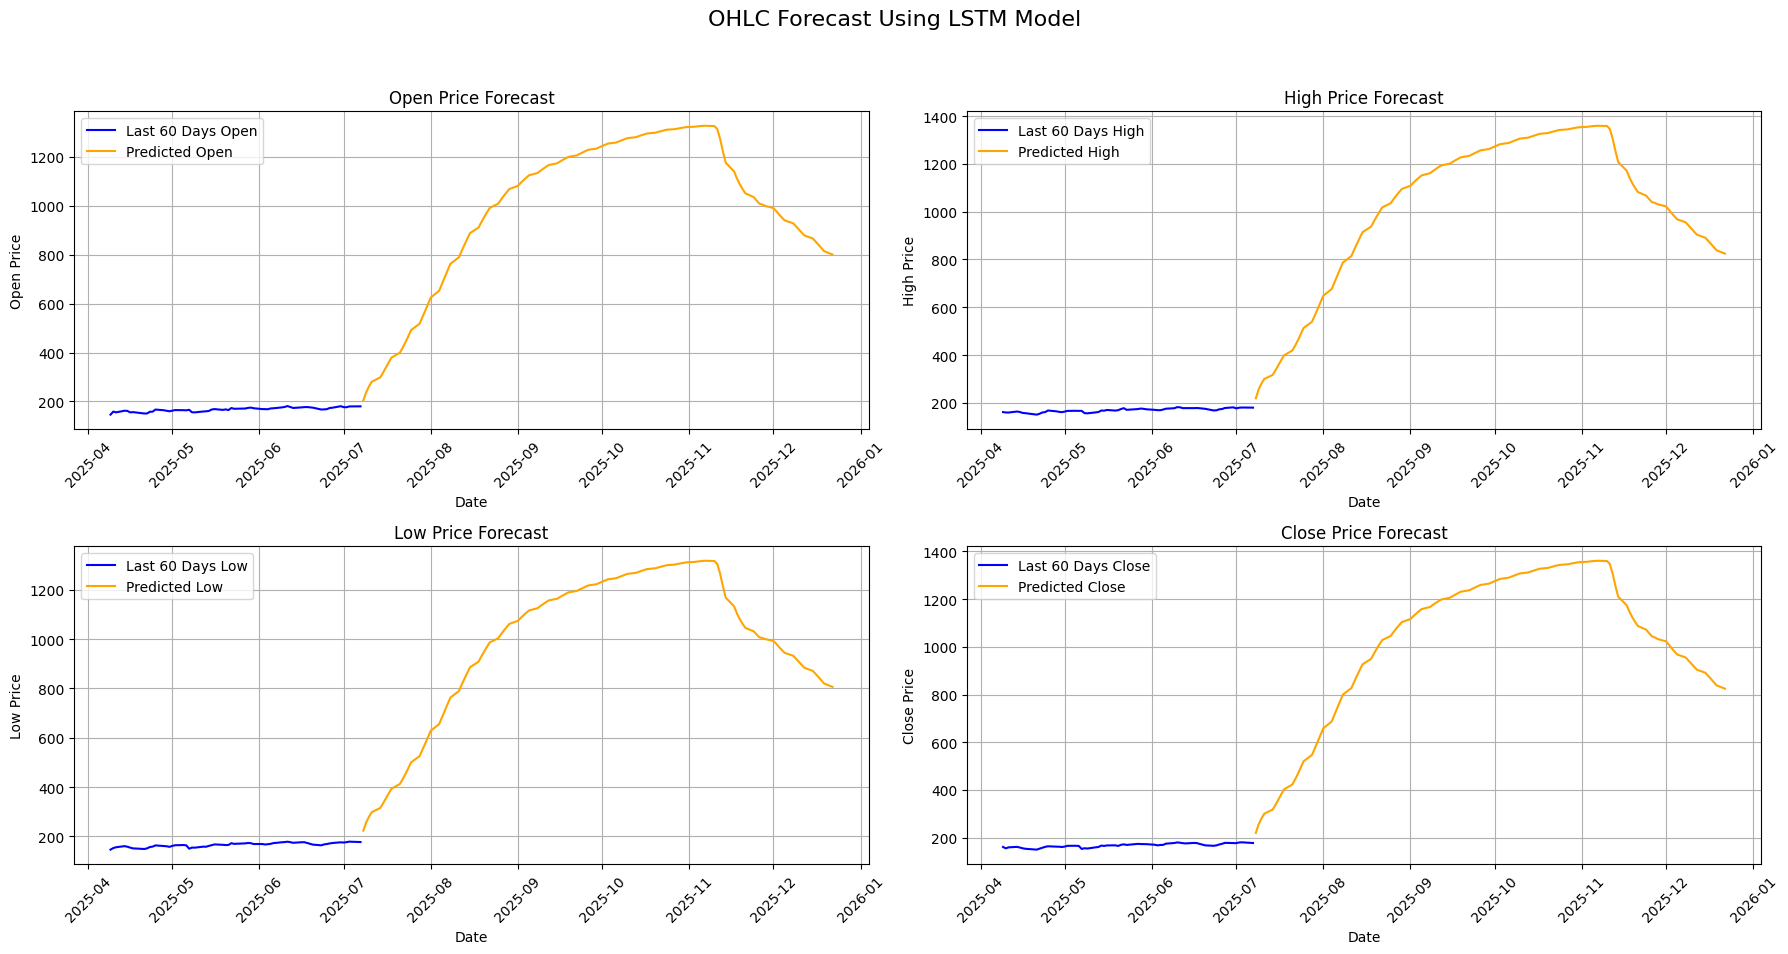

In [92]:
import matplotlib.pyplot as plt

# Get the last 60 actual days for plotting
last_60_actual = df[-60:][['open', 'high', 'low', 'close']].copy()

# Get predicted future OHLC (already extracted into df_working)
predicted_future_ohlc = df_working[-num_predictions:][['open', 'high', 'low', 'close']].copy()
predicted_future_ohlc.index = predicted_future_df.index  # Assign future dates as index

# Plotting
plt.figure(figsize=(18, 10))

for i, col in enumerate(['open', 'high', 'low', 'close']):
    plt.subplot(2, 2, i + 1)
    plt.plot(last_60_actual.index, last_60_actual[col], label=f'Last 60 Days {col.capitalize()}', color='blue')
    plt.plot(predicted_future_ohlc.index, predicted_future_ohlc[col], label=f'Predicted {col.capitalize()}', color='orange')
    plt.title(f'{col.capitalize()} Price Forecast')
    plt.xlabel("Date")
    plt.ylabel(f'{col.capitalize()} Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

plt.suptitle("OHLC Forecast Using LSTM Model", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
